# Splitting Larger Images into Smaller Ones

This notebook illustrates how to split larger images into smaller ones so that they are easier to ingest by the network model. 

In [1]:
# Load packages
import cv2 # for interactive drawing/labeling
from PIL import Image # for conversion to grayscale
import matplotlib.pyplot as plt # for plotting 
from glob import glob # for listing files
from tqdm import tqdm # for status bar during for loops

We'll start with one example, so that we are sure that the images are getting split properly.

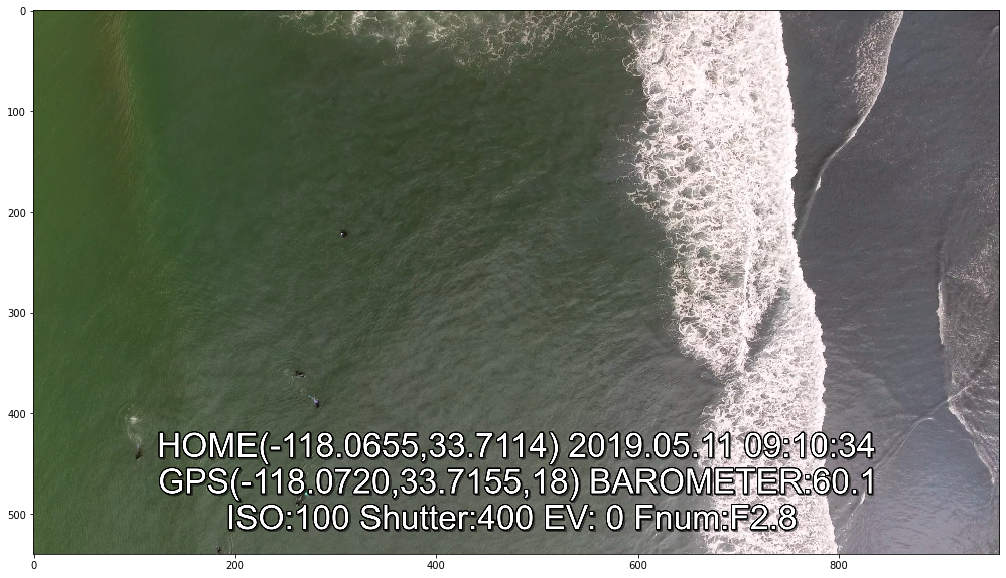

In [2]:
im = cv2.imread('data/raw/resized/vlcsnap-2019-10-03-13h43m35s494_resized.png') 
    # import example image
plt.figure(figsize=(20,10)) # set appropriate size
plt.imshow(im) # show image
plt.show() # show plot

In [3]:
# Here we will specify the number of splits to make. We want 25 total images.
M = im.shape[0]//5 # split the rows
N = im.shape[1]//5 # split the columns

# Split the image into 25 images
tiles = [im[x:x+M,y:y+N] for x in range(0,im.shape[0],M) for y in range(0,im.shape[1],N)]

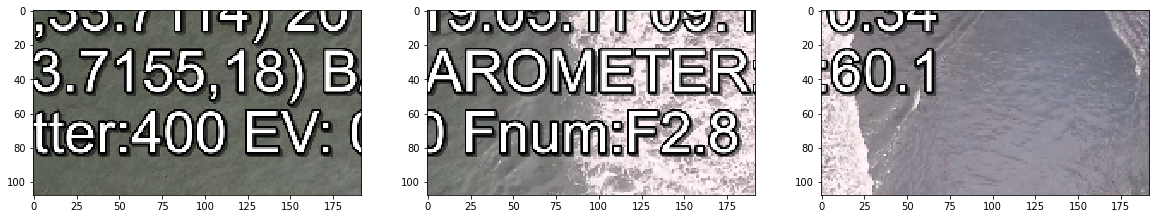

In [4]:
# Plot the last three images (lower right side) to see if it worked
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10)) # format subplots
ax1.imshow(tiles[22]) # show image
ax2.imshow(tiles[23]) # show image 
ax3.imshow(tiles[24]) # show image
plt.show() # show all images

It seems as though the original image was successfully split into 25 smaller images. We can now continue to do this for all images in our data folder. We will first convert these images to grayscale, because in the Photo Contrasts notebook, it appears that grayscale has the best contrast for identifying humans against the sand/ocean background. Next, we will split each image into 25 images. We will rename this file as filename_gs_number.png where gs means grayscale and number represents the split index (0 to 24). We have wrapped the files in tqdm() so that we can see the progress of the loop as it iterates.

In [5]:
raw_files = glob('data/raw/resized/*.png') # get all figures 

for file in tqdm(raw_files): # for each file
    im = cv2.imread(file) # read in the file
    #im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY) # convert to grayscale
    im = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
    tiles = [im[x:x+M,y:y+N] for x in range(0,im.shape[0],M) for y in range(0,im.shape[1],N)]
        # split into tiles
    for tile in range(len(tiles)): # for each tile
        filename = file.split('\\')[1] # grab the file name from the list of files
        filename = filename.split('.png')[0] # remove the .png
        cv2.imwrite('data/raw/resized/splits/'+filename+'_hsv_'+str(tile)+'.png',
                                tiles[tile]) # write the image to the file  
    

100%|██████████████████████████████████████████████████████████████████████████████| 2463/2463 [36:25<00:00,  1.13it/s]


Finally, we need to cut the processed (labeled) datasets into the same 25 individual images. We should save these values with the same nomenclature as their original images above: filename_gs_number.png. Here, the filename includes the word 'labeled' so that we can be sure that these are the labeled images and not the originals.

In [7]:
proc_files = glob('data/processed/dots/*.png') # get all figures 

for file in tqdm(proc_files): # for each file
    im = cv2.imread(file) # read in the file
    tiles = [im[x:x+M,y:y+N] for x in range(0,im.shape[0],M) for y in range(0,im.shape[1],N)]
        # split into tiles
    for tile in range(len(tiles)): # for each tile
        filename = file.split('\\')[1] # grab the file name from the list of files
        filename = filename.split('.png')[0] # remove the .png
        cv2.imwrite('data/processed/dots/splits/'+filename+'_gs_'+str(tile)+'.png',
                                tiles[tile]) # write the image to the file  

100%|████████████████████████████████████████████████████████████████████████████| 2463/2463 [1:46:39<00:00,  2.60s/it]


It appears that our model doesn't perform very well if there are a lot of 0s in the dataset (no people). Let's only save images in which there are people, and split that into smaller images (so that there are images with and without people) and train on that... It might work best that way. 

In [13]:
import pandas as pd
import shutil
import os

counts = pd.read_csv('data/processed/people_counts.csv')
counts = counts[counts.people > 0]

resized_list = list(counts.file+'_resized.png')
labeled_list = list(counts.file+'_labeled.png')

resized_source = 'data/raw/resized/'
resized_destination = 'data/raw/resized/with_people/'

labeled_source = 'data/processed/dots/'
labeled_destination = 'data/processed/dots/with_people/'

dest = [shutil.copyfile(resized_source+resized_list[x], resized_destination+resized_list[x]) 
        for x in range(len(resized_list))]
dest = [shutil.copyfile(labeled_source+labeled_list[x], labeled_destination+labeled_list[x]) 
        for x in range(len(labeled_list))]

In [19]:
raw_files = glob('data/raw/resized/with_people/*.png') # get all figures 

M = im.shape[0]//5 # split the rows
N = im.shape[1]//5 # split the columns

for file in tqdm(raw_files): # for each file
    im = cv2.imread(file) # read in the file
    #im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY) # convert to grayscale
    #im = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
    tiles = [im[x:x+M,y:y+N] for x in range(0,im.shape[0],M) for y in range(0,im.shape[1],N)]
        # split into tiles
    for tile in range(len(tiles)): # for each tile
        filename = file.split('\\')[1] # grab the file name from the list of files
        filename = filename.split('.png')[0] # remove the .png
        cv2.imwrite('data/raw/resized/with_people/splits/'+filename+'_full_color_'+str(tile)+'.png',
                                tiles[tile]) # write the image to the file  

100%|████████████████████████████████████████████████████████████████████████████████| 521/521 [23:44<00:00,  2.73s/it]


In [16]:
proc_files = glob('data/processed/dots/with_people/*.png') # get all figures 

M = im.shape[0]//5 # split the rows
N = im.shape[1]//5 # split the columns

for file in tqdm(proc_files): # for each file
    im = cv2.imread(file) # read in the file
    tiles = [im[x:x+M,y:y+N] for x in range(0,im.shape[0],M) for y in range(0,im.shape[1],N)]
        # split into tiles
    for tile in range(len(tiles)): # for each tile
        filename = file.split('\\')[1] # grab the file name from the list of files
        filename = filename.split('.png')[0] # remove the .png
        cv2.imwrite('data/processed/dots/with_people/splits/'+filename+'_gs_'+str(tile)+'.png',
                                tiles[tile]) # write the image to the file  

100%|████████████████████████████████████████████████████████████████████████████████| 521/521 [20:26<00:00,  2.35s/it]
